# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import History 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training:
* Typical filename: 
    * ReadOut-xx_Watch-y_zzzz.jpg 
    * e.g. "ReadOut-54_Watch-4_1667.jpg"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **xx**          | readout value               | **to be learned** |
| y           | different analog watches    | ignored      |
| zzzz        | running number              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    
    target_number = (int(base[8:10])) / 100
    target_number_shifted = (target_number + 0.5) % 1
    if (target_number <= 0.25) or (target_number > 0.75):
        target_select = 0
    else:
        target_select = 1

    x_data.append(test_image)
    zw = np.array([target_number, target_number_shifted, target_select])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2883, 32, 32, 3)
(2883, 3)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (3)

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(3))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. 
This is implemented with a ImageDataGenerator.
Typically 60 epochs of learning are sufficient

In [4]:
Batch_Size = 8
Epoch_Anz = 60
Shift_Range = 1
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
289/289 [==============================] - 10s 34ms/step - loss: 0.0974 - acc: 0.6275 - val_loss: 0.0173 - val_acc: 0.9272
Epoch 2/60
289/289 [==============================] - 11s 37ms/step - loss: 0.0202 - acc: 0.9423 - val_loss: 0.0097 - val_acc: 0.9792
Epoch 3/60
289/289 [==============================] - 11s 39ms/step - loss: 0.0131 - acc: 0.9636 - val_loss: 0.0110 - val_acc: 0.9827
Epoch 4/60
289/289 [==============================] - 12s 42ms/step - loss: 0.0094 - acc: 0.9779 - val_loss: 0.0053 - val_acc: 0.9913
Epoch 5/60
289/289 [==============================] - 12s 41ms/step - loss: 0.0076 - acc: 0.9814 - val_loss: 0.0051 - val_acc: 0.9913
Epoch 6/60
289/289 [==============================] - 12s 42ms/step - loss: 0.0065 - acc: 0.9831 - val_loss: 0.0075 - val_acc: 0.9896
Epoch 7/60
289/289 [==============================] - 11s 36ms/step - loss: 0.0048 - acc: 0.9883 - val_loss: 0.0031 - val_acc: 0.9931
Epoch 8/60
289

Epoch 37/60
289/289 [==============================] - 13s 45ms/step - loss: 8.9663e-04 - acc: 0.9983 - val_loss: 7.0187e-04 - val_acc: 0.9965
Epoch 38/60
289/289 [==============================] - 12s 41ms/step - loss: 9.3962e-04 - acc: 0.9978 - val_loss: 6.9835e-04 - val_acc: 0.9948
Epoch 39/60
289/289 [==============================] - 11s 37ms/step - loss: 7.2239e-04 - acc: 0.9974 - val_loss: 0.0023 - val_acc: 0.9809
Epoch 40/60
289/289 [==============================] - 11s 37ms/step - loss: 9.1567e-04 - acc: 0.9952 - val_loss: 9.2359e-04 - val_acc: 0.9983
Epoch 41/60
289/289 [==============================] - 11s 38ms/step - loss: 9.2629e-04 - acc: 0.9948 - val_loss: 9.1592e-04 - val_acc: 0.9965
Epoch 42/60
289/289 [==============================] - 10s 36ms/step - loss: 4.5983e-04 - acc: 0.9991 - val_loss: 0.0013 - val_acc: 0.9948
Epoch 43/60
289/289 [==============================] - 11s 39ms/step - loss: 8.6767e-04 - acc: 0.9965 - val_loss: 8.1648e-04 - val_acc: 0.9983
Epoch 4

Learing result
 
* Visualization of the training and validation results

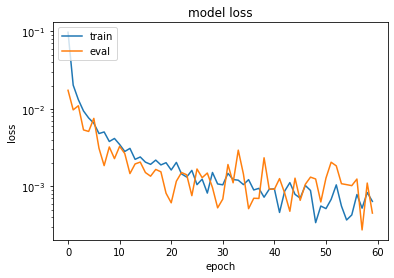

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).

In [6]:
Input_dir='data_resize_all'
files = glob.glob(Input_dir + '/*.*')
res = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (int(base[8:10])) / 100
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_orginal = round(classes[0][0], 2)  # Value 1
    out_shifted = round(classes[0][1], 2)  # Value 2 (target - 0.5)
    out_select = round(classes[0][2], 2)  # 1 = Value 1, 0 = Value 2
    if out_select < 0.5:
        combinded = (out_shifted - 0.5) % 1
    else:
        combinded = out_orginal % 1
      
    dev1 = target - combinded
    dev2 = target - (combinded - 1)
    dev3 = target - (combinded + 1)
               
    deviation = dev1;
    if abs(dev2) < abs(deviation):
        deviation = dev2
    if abs(dev3) < abs(deviation):
        deviation = dev3
    res.append(np.array([target, out_orginal, out_shifted, out_select, combinded, deviation]))
#    print(base, ', ', zw1, ', ', round(zw2, 2), ', ', round(zw3, 2), ', ', round(zw4, 2))

res = np.asarray(res)
res_step_1 = res

## Results

### Metric 1

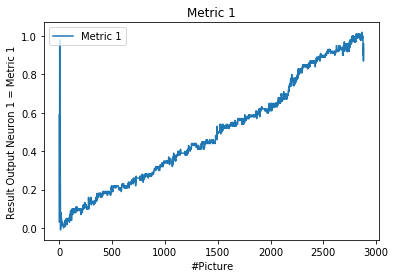

In [7]:
plt.plot(res[:,1])
plt.title('Metric 1')
plt.ylabel('Result Output Neuron 1 = Metric 1')
plt.xlabel('#Picture')
plt.legend(['Metric 1'], loc='upper left')
plt.show()

### Metric 2

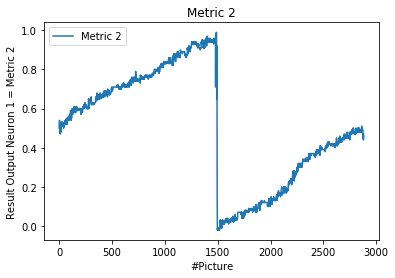

In [8]:
plt.plot(res[:,2])
plt.title('Metric 2')
plt.ylabel('Result Output Neuron 1 = Metric 2')
plt.xlabel('#Picture')
plt.legend(['Metric 2'], loc='upper left')
plt.show()

### Selector Neuron

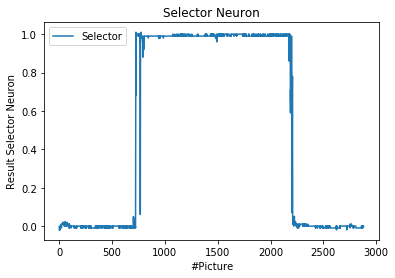

In [9]:
plt.plot(res[:,3])
plt.title('Selector Neuron')
plt.ylabel('Result Selector Neuron')
plt.xlabel('#Picture')
plt.legend(['Selector'], loc='upper left')
plt.show()

### Deviation from Expected Value

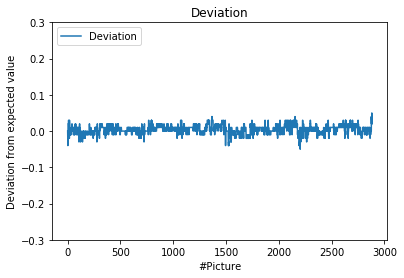

[ 0.0035  0.0118 -0.05    0.05  ]


In [10]:
plt.plot(res[:,5])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,5]), np.std(res[:,5]), np.min(res[:,5]), np.max(res[:,5])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [11]:
model.save("Train_CNN_Version2_1_Analog-Readout.h5")